In [4]:
#Google colab FILE

%matplotlib inline
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc
import glob 

## Sample Training Image data

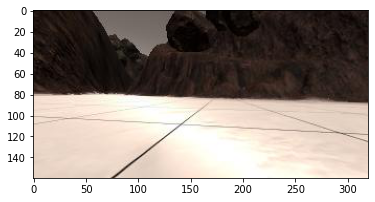

In [5]:
path = 'data/IMG/*'
img_list = glob.glob(path)
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

## Perspective Transform using Calibration Images





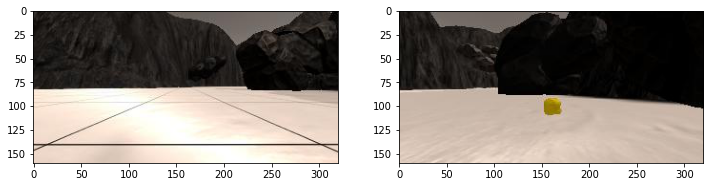

In [6]:
example_grid = 'calibration_images/example_grid1.jpg'
example_rock = 'calibration_images/example_rock1.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

## Perspective Transform

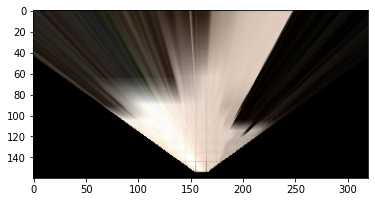

In [7]:
#Perform a perspective transform
def perspect_transform(img, src, dst):
           
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    
    return warped

dst_size = 5 
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
warped = perspect_transform(grid_img, source, destination)
plt.imshow(warped)
#scipy.misc.imsave('../output/warped_example.jpg', warped)

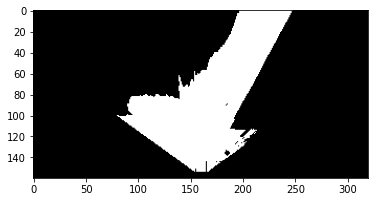

In [8]:
#Colour threshold -  Identify pixels above the threshold
def color_thresh(img, rgb_threshold_min=(160, 160, 160),rgb_threshold_max=(255,255,255)):
    color_select = np.zeros_like(img[:,:,0])
    above_thresh = (img[:,:,0] >= rgb_threshold_min[0]) & (img[:,:,0] <= rgb_threshold_max[0]) & \
                   (img[:,:,1] >= rgb_threshold_min[1]) & (img[:,:,1] <= rgb_threshold_max[1]) & \
                   (img[:,:,2] >= rgb_threshold_min[2]) & (img[:,:,2] <= rgb_threshold_max[2]) 
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

threshed = color_thresh(warped)
plt.imshow(threshed, cmap='gray')
#scipy.misc.imsave('../output/warped_threshed.jpg', threshed*255)

## Coordinate Transform

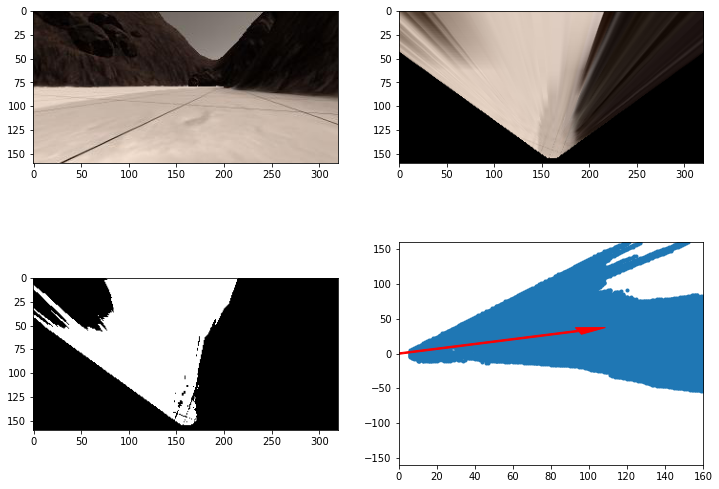

In [9]:
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = np.absolute(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[0]).astype(np.float)
    return x_pixel, y_pixel

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to apply a rotation to pixel positions
def rotate_pix(xpix, ypix, yaw):
    # TODO:
    # Convert yaw to radians
    # Apply a rotation
    xpix_rotated = 0
    ypix_rotated = 0
    # Return the result  
    return xpix_rotated, ypix_rotated

# Define a function to perform a translation
def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # TODO:
    # Apply a scaling and a translation
    xpix_translated = 0
    ypix_translated = 0
    # Return the result  
    return xpix_translated, ypix_translated

# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

# Grab another random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
warped = perspect_transform(image, source, destination)
threshed = color_thresh(warped)

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(threshed)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshed, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)

In [10]:
# Import pandas and read in csv file as a dataframe
import pandas as pd
# Change the path below to your data directory
# If you are in a locale (e.g., Europe) that uses ',' as the decimal separator
# change the '.' to ','
df = pd.read_csv('data/robot_log.csv', delimiter=';', decimal='.')
csv_img_list = df["Path"].tolist() # Create list of image pathnames
# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)

# Creating a class to be the data container
# Will read in saved data from csv file and populate this object
# Worldmap is instantiated as 200 x 200 grids corresponding 
# to a 200m x 200m space (same size as the ground truth map: 200 x 200 pixels)
# This encompasses the full range of output position values in x and y from the sim
class Databucket():
    def __init__(self):
        self.images = csv_img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = -1 # This will be a running index, setting to -1 is a hack
                        # because moviepy (below) seems to run one extra iteration
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d # Ground truth worldmap

# Instantiate a Databucket().. this will be a global variable/object
# that you can refer to in the process_image() function below
data = Databucket()

In [11]:
# Define a function to pass stored images to
# reading rover position and yaw angle from csv file
# This function will be used by moviepy to create an output video
def get_source():
    return np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])

def get_destination(img):
    dst_size =5
    bottom_offset =6
    img_size = (img.shape[1], img.shape[0])
    destination = np.float32([[img_size[0]/2 - dst_size, img_size[1] - bottom_offset],
                      [img_size[0]/2 + dst_size, img_size[1] - bottom_offset],
                      [img_size[0]/2 + dst_size, img_size[1] - 2*dst_size - bottom_offset],
                      [img_size[0]/2 - dst_size, img_size[1] - 2*dst_size - bottom_offset],
                      ])
    return destination
    
    
    
def process_image(img):
    # Example of how to use the Databucket() object defined above
    # to print the current x, y and yaw values 
    # print(data.xpos[data.count], data.ypos[data.count], data.yaw[data.count]) 
    
    # 1) Define source and destination points for perspective transform
    source = get_source()
    destination = get_destination(img)
    
    # 2) Apply perspective transform
    warped = perspect_transform(img,source,destination)
    
    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    
    # Threshold of RGB > 160 does a nice job of identifying ground pixels only
    image_threshold = color_thresh(warped,rgb_threshold_min=(160,160,160),rgb_threshold_max=(255,255,255))
    
    # Minimum Threshold of RGB (199,174,36) and maximum threshold of RGB (137,111,13) for rock
    image_rock_threshold = color_thresh(warped,rgb_threshold_min=(199,174,36),rgb_threshold_max=(137,111,13))
    
    #Minimum obstacle treshold of RGB (2,2,2) and maximum obstacle threshold of RGB (45,45,45)
    image_obstale_threshold = color_thresh(warped,rgb_threshold_min=(2,2,2),rgb_threshold_max=(45,45,45))
    
    # 4) Convert thresholded image pixel values to rover-centric coords
    
    # For Image
    x_pix, y_pix = rover_coords(image_threshold)
    
    # For Rock
    x_pix_rock, y_pix_rock = rover_coords(image_rock_threshold)
    
    # For Obstacles
    x_pix_obstacle, y_pix_obstacle = rover_coords(image_obstale_threshold)
    
    # 5) Convert rover-centric pixel values to world coords
    world_size =200
    scale =10
    # navigation
    navigable_x_world, navigable_y_world = pix_to_world(x_pix, y_pix,data.xpos[data.count], data.ypos[data.count], data.yaw[data.count],world_size, scale)
    # rock
    rock_x_world,rock_y_world = pix_to_world(x_pix_rock, y_pix_rock,data.xpos[data.count], data.ypos[data.count], data.yaw[data.count],world_size, scale)
    # Obstacle
    obst_x_world, obst_y_world = pix_to_world(x_pix_obstacle, y_pix_obstacle,data.xpos[data.count], data.ypos[data.count], data.yaw[data.count],world_size, scale)
    
    # 6) Update worldmap (to be displayed on right side of screen)
    data.worldmap[obst_y_world, obst_x_world, 0] += 255
    data.worldmap[rock_y_world, rock_x_world, 1] += 255
    data.worldmap[navigable_y_world, navigable_x_world, 2] += 255 

    # 7) Make a mosaic image, below is some example code
        # First create a blank image (can be whatever shape you like)
    output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3))
        # Next you can populate regions of the image with various output
        # Here I'm putting the original image in the upper left hand corner
    output_image[0:img.shape[0], 0:img.shape[1]] = img

        # Let's create more images to add to the mosaic, first a warped image
    warped = perspect_transform(img, source, destination)
        # Add the warped image in the upper right hand corner
    output_image[0:img.shape[0], img.shape[1]:] = warped

        # Overlay worldmap with ground truth map
    map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.5, 0)
        # Flip map overlay so y-axis points upward and add to output_image 
    output_image[img.shape[0]:, 0:data.worldmap.shape[1]] = np.flipud(map_add)


        # Then putting some text over the image
    cv2.putText(output_image,"Populate this image with your analyses to make a video!", (20, 20), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    data.count += 1 # Keep track of the index in the Databucket()
    
    return output_image

In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1236992/45929032 bytes (2.7%)3547136/45929032 bytes (7.7%)6856704/45929032 bytes (14.9%)10403840/45929032 bytes (22.7%)13508608/45929032 bytes (29.4%)17072128/45929032 bytes (37.2%)20226048/45929032 bytes (44.0%)23461888/45929032 bytes (51.1%)26820608/45929032 bytes (58.4%)30302208/45929032 bytes (66.0%)33669120/45929032 bytes (73.3%)36765696/45929032 bytes (80.0%)3

In [13]:
# Define pathname to save the output video
output = 'sample_train_run1.mp4'
data = Databucket() # Re-initialize data in case you're running this cell multiple times
clip = ImageSequenceClip(data.images, fps=60) # Note: output video will be sped up because 
                                          # recording rate in simulator is fps=25
new_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time new_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video sample_train_run1.mp4
[MoviePy] Writing video sample_train_run1.mp4


100%|██████████| 462/462 [00:09<00:00, 48.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: sample_train_run1.mp4 

CPU times: user 6.84 s, sys: 301 ms, total: 7.14 s
Wall time: 9.83 s
